In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import gpflow as gpf
import numpy as np
gpf.config.set_default_float(np.float32)

gpf.config.set_default_jitter(tf.cast(1e-6, dtype=gpf.default_float()))
from onoffgpf import OnOffSVGP, OnOffLikelihood
from onoffgpf.PlotOnOff1D import PlotOnOff1D

from gpflow import conditionals

import gpflow

import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
matdata = sio.loadmat('data/toydata.mat')
Xtrain = matdata['x'].astype(gpf.default_float())
Ytrain = matdata['y'].astype(gpf.default_float())

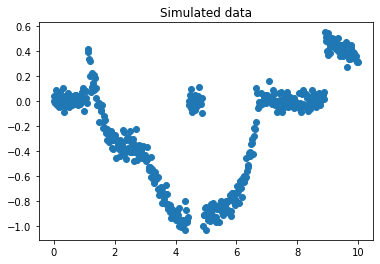

In [3]:
plt.scatter(Xtrain,Ytrain)
plt.title("Simulated data")
plt.show()

In [4]:
num_inducing   = 10

# initalize kernel parameters
kf = gpf.kernels.RBF(variance=1, lengthscales=2)

kg = gpf.kernels.RBF(variance=5, lengthscales=2)

# initialise equally spaced inducing point locations
Zf = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)
Zg = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)

In [5]:
# model definition
m = OnOffSVGP(Xtrain, Ytrain
              ,kernf=kf,kerng=kg
              ,likelihood = OnOffLikelihood()
              ,Zf = Zf,Zg = Zg
             )

# make variance trainable
m.likelihood.variance.assign(0.01)
from gpflow import set_trainable
set_trainable(m.likelihood.variance, True)

In [6]:
N=len(Xtrain)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(Xtrain,),
                                                    tf.convert_to_tensor(Ytrain,)),)#.repeat().shuffle(N)


In [7]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(
    m.training_loss_closure(compile=True),
    m.trainable_variables,
    options={'maxiter':(80000), 'ftol':1e-64, 'gtol':1e-64, 'factr':-1e-64},
)

/home/kheuton/anaconda3/envs/port_zigp/lib/python3.10/site-packages/gpflow/optimizers/scipy.py:94: OptimizeWarning: Unknown solver options: factr
  return scipy.optimize.minimize(


      fun: -250.92999267578125
 hess_inv: <59x59 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.66435587,  -1.66557801,  -0.88997078,   2.25598526,
        -0.86288762,  -1.19303417,  -5.09846497,  -2.61406088,
         2.12940073,  -4.46428967,  -0.37319469,  -8.97860146,
        -4.66442871,  -0.22253418, -14.1953125 ,  -0.35437012,
        17.27494812,   0.64152974,   6.07321644,  -7.19548178,
       -12.74250507,   3.82614613,  -6.87687874,   6.36336136,
         2.65513229,   6.81205368,  -2.63432574,  -0.78418845,
        -0.58541441,   1.05134475,   0.20035672,   0.50594997,
        -0.3968721 ,   2.08629322,   0.51150548,  -0.71317285,
        -0.24537659,  -1.17516565,  -6.49056435,  -1.17374325,
        -0.14087296,   1.34646225,   0.52105999,  -2.38028717,
        -0.58681881,  -0.19978178,  -0.11898035,  -0.87145996,
        -0.97358316,  -0.89292789,  -0.86922401,   0.34034169,
         1.17288899,  -0.81315637,   3.70541954,   0.37597656,
        -8.5829238

In [8]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = train_dataset#iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.005)#gpflow.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf
logf = run_adam(m, 80000)

In [9]:
%%time
run_adam(m, 80000)

CPU times: user 4min 46s, sys: 2min 22s, total: 7min 9s
Wall time: 1min 56s


[-239332.6,
 -118942.31,
 -68878.47,
 -44529.29,
 -32468.354,
 -25651.188,
 -21130.611,
 -18007.701,
 -15760.1,
 -13961.452,
 -12515.45,
 -11351.035,
 -10359.284,
 -9535.291,
 -8830.668,
 -8219.764,
 -7689.783,
 -7222.7812,
 -6815.7354,
 -6448.126,
 -6131.7334,
 -5843.086,
 -5580.7383,
 -5344.0854,
 -5127.333,
 -4934.8145,
 -4759.034,
 -4597.476,
 -4446.953,
 -4307.7637,
 -4183.6816,
 -4062.5745,
 -3950.04,
 -3847.7803,
 -3750.1318,
 -3660.6138,
 -3574.2397,
 -3492.0789,
 -3414.655,
 -3342.5103,
 -3271.7488,
 -3203.1904,
 -3138.5085,
 -3076.5522,
 -3015.76,
 -2958.1267,
 -2903.0,
 -2848.6206,
 -2796.9727,
 -2744.4966,
 -2696.176,
 -2647.8638,
 -2601.6602,
 -2556.2698,
 -2510.4468,
 -2468.3623,
 -2426.0964,
 -2385.6274,
 -2344.46,
 -2305.1826,
 -2266.7966,
 -2228.9683,
 -2192.6174,
 -2156.7537,
 -2121.4688,
 -2086.8154,
 -2052.3914,
 -2019.529,
 -1986.989,
 -1955.1666,
 -1923.9951,
 -1893.5374,
 -1862.7712,
 -1833.458,
 -1804.3806,
 -1775.3396,
 -1747.582,
 -1720.0525,
 -1693.3201,
 -16

In [9]:
logf[-1]

506.9909

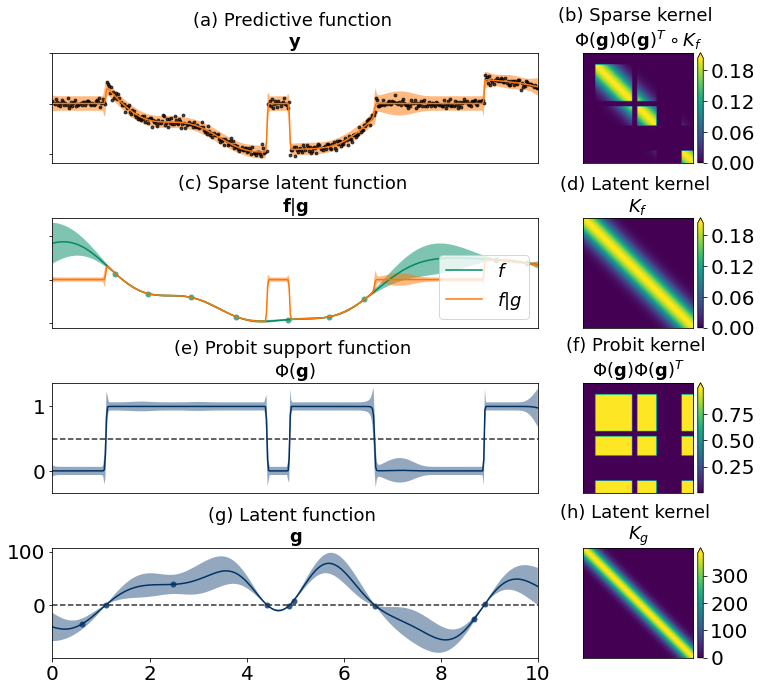

In [10]:
# model plot
PlotOnOff1D(m)

In [11]:
def normcdf(x):
    return 0.5 * (1.0 + tf.math.erf(x / np.sqrt(2.0))) * (1. - 2.e-3) + 1.e-3

In [47]:
num_samples = 100000
data_shape = m.X.shape
u = tf.random.normal(shape=data_shape+(num_samples,))
w = tf.random.normal(shape=data_shape+(num_samples,))
v = tf.random.normal(shape=data_shape+(num_samples,))

In [48]:
fmean, fvar = conditionals.conditional(m.X, m.Zf, m.kernf, m.u_fm,
                                               full_cov=False, q_sqrt=m.u_fs_sqrt, )
fmean = fmean + m.mean_function(m.X)

gmean, gvar = conditionals.conditional(m.X, m.Zg, m.kerng, m.u_gm,
                                       full_cov=False, q_sqrt=m.u_gs_sqrt, )

In [49]:
# Expand dims to give the mean a sample dimension
g_mean_NDS = tf.expand_dims(gmean, -1)
g_std_NDS = tf.expand_dims(tf.math.sqrt(gvar), -1)
g_samples = g_mean_NDS + u*g_std_NDS
phi_g_samples = normcdf(g_samples)

In [50]:
# Expand dims to give the mean a sample dimension
f_mean_NDS = tf.expand_dims(fmean, -1)
f_var_NDS = tf.expand_dims(fvar, -1)
f_std_NDS = tf.math.sqrt(f_var_NDS)
f_samples = f_mean_NDS*phi_g_samples + w*f_std_NDS*phi_g_samples


In [51]:
y_normal = tfp.distributions.Normal(loc=f_samples, scale=tf.math.sqrt(m.likelihood.variance))
py = y_normal.log_prob(tf.expand_dims(m.Y,-1))

qf_var_exp = 1/(2*m.likelihood.variance) * phi_g_samples * phi_g_samples * f_var_NDS

In [72]:
py_scipy = scipy.stats.norm.logpdf(tf.expand_dims(m.Y,-1), f_samples, tf.math.sqrt(m.likelihood.variance))

In [52]:
elbo_likelihood = py - qf_var_exp

# reduce samples
py_over_samples = tf.reduce_mean(py, -1)
elbo_likelihood_over_samples = tf.reduce_mean(elbo_likelihood, -1)
# reduce data
elbo_likelihood_over_data = tf.reduce_sum(elbo_likelihood_over_samples)
py_over_data = tf.reduce_sum(py_over_samples)
py_over_data

<tf.Tensor: shape=(), dtype=float32, numpy=642.3896>

In [53]:
# probit transformed expectations for  gamma
ephi_g, ephi2_g, evar_phi_g = m.ProbitExpectations(gmean, gvar)

# compute augmented f
# from above computations we have
# p(f)   = N(f| A*u_fm, Kfnn + A(u_fs - Kfmm)t(A))  A = Kfnm*inv(Kfmm)
# p(f|g) = N(f| diag(ephi_g)* A*u_fm, diag(evar_phi_g)) * (Kfnn + A(u_fs - Kfmm)t(A)))
gfmean = tf.multiply(ephi_g, fmean)
gfvar = tf.multiply(ephi2_g, fvar)
gfmeanu = tf.multiply(evar_phi_g, tf.square(fmean))

var_exp = m.likelihood.variational_expectations(gfmean, gfvar, gfmeanu, m.Y)
tf.reduce_sum(var_exp)

<tf.Tensor: shape=(), dtype=float32, numpy=603.11>

Text(0.5, 1.0, 'Absolute Difference between analytic and MC estimate of p(y|f) \n 100,000 samples')

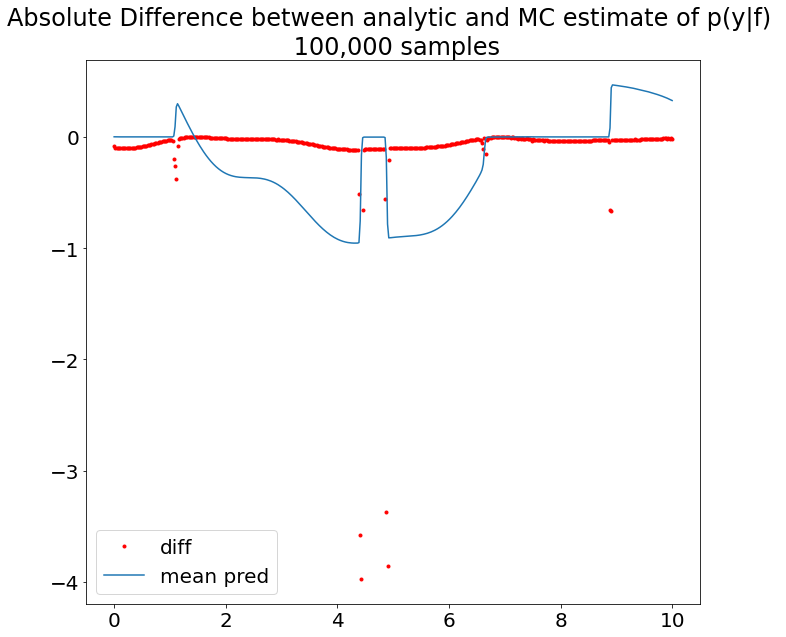

In [55]:
plt.plot()
plt.plot(m.X, var_exp-py_over_samples, 'r.', label='diff')
plt.plot(m.X, tf.reduce_mean(f_samples,-1), label='mean pred')
plt.legend()
plt.title('Absolute Difference between analytic and MC estimate of p(y|f) \n 100,000 samples')

In [36]:
np.max(var_exp-py_over_samples)

0.0004862547

In [60]:
from scipy.special import owens_t


def CustProbitExpectations(gmean, gvar):
    """
        Compute expectation of probit transformed gaussian variables
        pgmean = \int Phi(g) q(g) dg
        pgmeansq = \int Phi^2(g) q(g) dg
        pgvar = \int Var(Phi(g)) q(g) dg
    """

    def normcdf(x):
        return 0.5 * (1.0 + tf.math.erf(x / np.sqrt(2.0))) * (1. - 2.e-3) + 1.e-3


    z = gmean / tf.sqrt(1. + gvar)
    a = 1 / tf.sqrt(1. + (2 * gvar))

    cdfz = normcdf(z)
    tz = owens_t(z, a)

    pgmean = cdfz
    pgmeansq = (cdfz - 2. * tz)
    pgvar = (cdfz - 2. * tz - tf.square(cdfz))

    # clip negative values from variance terms to zero
    pgmeansq = (pgmeansq + tf.abs(pgmeansq)) / 2.
    pgvar = (pgvar + tf.abs(pgvar)) / 2.

    return pgmean, pgmeansq, pgvar

In [66]:
# probit transformed expectations for  gamma
cephi_g, cephi2_g, cevar_phi_g = CustProbitExpectations(gmean, gvar)

# compute augmented f
# from above computations we have
# p(f)   = N(f| A*u_fm, Kfnn + A(u_fs - Kfmm)t(A))  A = Kfnm*inv(Kfmm)
# p(f|g) = N(f| diag(ephi_g)* A*u_fm, diag(evar_phi_g)) * (Kfnn + A(u_fs - Kfmm)t(A)))
cgfmean = tf.multiply(cephi_g, fmean)
cgfvar = tf.multiply(cephi2_g, fvar)
cgfmeanu = tf.multiply(cevar_phi_g, tf.square(fmean))

cvar_exp = m.likelihood.variational_expectations(cgfmean, cgfvar, cgfmeanu, m.Y)
tf.reduce_sum(var_exp)

<tf.Tensor: shape=(), dtype=float32, numpy=603.11>

In [65]:
np.isclose(cephi2_g, ephi2_g).min()

False

In [70]:
?

In [68]:
import scipy